In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

In [25]:
def negative_entropy(spectrogram: np.ndarray, min_temp=0, max_temp=5, out_channels=64):
    # spectrogram.shape = [C, N]
    temperature = np.linspace(min_temp, max_temp, out_channels)[None, None, :]
    exp = np.exp((spectrogram - np.max(spectrogram, axis=0))[:, :, None] / (np.e ** temperature))
    probs = exp / np.sum(exp, axis=0)
    entropy = np.transpose(-np.sum(probs * np.log(probs + 1e-8), axis=0), axes=(1, 0))
    return -entropy

def scaled_negative_entropy(spectrogram: np.ndarray, min_temp=0, max_temp=5, out_channels=64):
    nent = negative_entropy(spectrogram, min_temp=min_temp, max_temp=max_temp, out_channels=out_channels)
    nent = nent / -(np.min(nent) - np.max(nent))
    return nent

In [41]:
def audio_transform(signal: np.ndarray, sr: int):
    n_fft = 512
    melspectrogram = librosa.feature.melspectrogram(y=signal, sr = sr,
												n_mels = 64, n_fft=n_fft, hop_length=n_fft // 4)
    return torch.as_tensor(melspectrogram / np.max(melspectrogram))


In [43]:
n_fft = 512
n_channels = 64
audio_dir = 'morse_dataset'

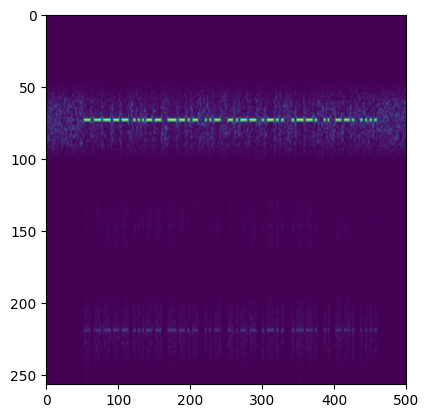

In [44]:
signal, sr = librosa.load(Path(audio_dir, '1.opus'), sr=None)
spectrogram = np.abs(librosa.stft(signal, n_fft=n_fft))
plt.imshow(spectrogram, aspect=2)

-0.9999999981978547 1.8021453678823644e-09
(64, 501)


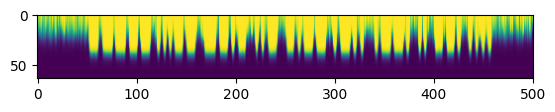

In [28]:
ne = scaled_negative_entropy(spectrogram)
print(np.min(ne), np.max(ne))
print(ne.shape)
plt.imshow(ne)

In [30]:
def load_audio_in_memory(audio_dir, filenames, transform=lambda x, y: x):
    records = []
    for name in tqdm(filenames):
        signal, sr = librosa.load(Path(audio_dir, name), sr=None)
        records.append(transform(signal, sr))
    return records

In [37]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_filenames = (list(train_df['id']) + list(test_df['id']))
len(all_filenames)

35000

## entropy

In [63]:
dir_to_save = f'data/entropy_nfft{n_fft}_nc{n_channels}'
Path(dir_to_save).mkdir(exist_ok=True)

for name in tqdm(all_filenames):
    signal, sr = librosa.load(Path(audio_dir, name), sr=None)
    spectrogram = np.abs(librosa.stft(signal, n_fft=n_fft))
    ne = scaled_negative_entropy(spectrogram, out_channels=n_channels)
    # print(ne.dtype)
    ne = torch.as_tensor(ne, dtype=torch.float32)
    # print(ne.dtype)
    torch.save(ne, Path(dir_to_save, Path(name).with_suffix('.pt')))

100%|██████████| 35000/35000 [2:06:12<00:00,  4.62it/s]  


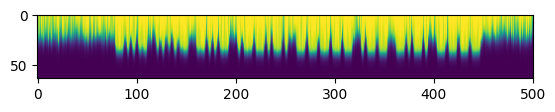

In [68]:
plt.imshow(torch.load(Path(dir_to_save, '3234.pt')))

In [1]:
plt.imshow(torch.load(Path(dir_to_save, '1.pt')))

NameError: name 'plt' is not defined